# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [58]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans,KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [9]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()
#display(azdias.describe())
#azdias.columns

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [5]:
azdias_clone = azdias.copy()

In [8]:
#columns contain string type
df_subset = azdias_clone.select_dtypes(exclude=[np.number])

In [9]:
df_subset.columns 

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [10]:
# data review and verification
#print('{:*^50}'.format('Data overview:'))
#print(azdias_clone.head(2))  # print first two data rows
print('{:*^50}'.format('Data dtypes:'))
print(pd.DataFrame(azdias_clone.dtypes).T)  # print data distribution
print('{:*^50}'.format(' NA counts:'))
print(pd.DataFrame(azdias_clone.isnull().sum()).T)  # view missing data
print('{:*^50}'.format('Data DESC:'))
print(azdias_clone.describe().round(2).T)  # Print raw data basic descriptive information
print('{:*^50}'.format('Correlation analysis:'))
print(azdias_clone.corr().round(2).T)  # Print raw data correlation information

*******************Data dtypes:*******************
     LNR AGER_TYP AKT_DAT_KL ALTER_HH ALTER_KIND1 ALTER_KIND2 ALTER_KIND3  \
0  int64    int64    float64  float64     float64     float64     float64   

  ALTER_KIND4 ALTERSKATEGORIE_FEIN ANZ_HAUSHALTE_AKTIV         ...           \
0     float64              float64             float64         ...            

       VHN VK_DHT4A VK_DISTANZ  VK_ZG11 W_KEIT_KIND_HH WOHNDAUER_2008  \
0  float64  float64    float64  float64        float64        float64   

  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0  float64    int64     int64                int64  

[1 rows x 366 columns]
******************* NA counts:********************
   LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  \
0    0         0       73499     73499       810163       861722       885051   

   ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0       890016                262947                93148   

           ...       

In [11]:
def convert_all_feature(conver_cols, convert_matrix):
    """
    This function is to convert all values of feature array
    The parameters: "conver_cols" contains all column names of features.
                    "convert_matrix" is data matrix.
    """
    for each_col in conver_cols:  # Convert by each column
        each_data = convert_matrix[each_col]  # Get each column data
        model_le = LabelEncoder()  # Builde model objects    

        if np.issubdtype(each_data.dtype, np.number):
            each_con_data = each_data.astype(str)
        else:
            each_con_data = model_le.fit_transform(each_data.astype(str))  # convert directly

        convert_matrix[each_col] = each_con_data  # Replace the original value with the converted value
        convert_matrix[each_col] = convert_matrix[each_col].replace('nan', 0) #Replace all 'nan' value to 0
       
convert_all_feature(df_subset.columns, azdias_clone)

#convert_all_feature(azdias_clone.columns, azdias_clone)

In [19]:
azdias_clone[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,45,19,43,35,5162,2
1,35,15,35,35,2,1
2,15,7,13,30,3,1
3,5,3,1,30,905,1
4,25,11,29,24,3,1
5,37,15,39,11,3,1
6,13,7,9,30,3,1
7,8,3,5,30,2,1
8,0,1,3,35,2,1
9,4,1,7,17,2,1


In [ ]:
def Standardizing_features(df):
    features = df.columns
    # Separating out the features
    x = df.loc[:, features].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

standardized_df = Standardizing_features(azdias_clone)

In [ ]:
def pca_model(component_number, df):
    
    cols = []
    for i in range(component_number):
        cols.append('principal component {}'.format(i))
        
    pca = PCA(n_components=component_number)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents, columns = cols)
    
    return principalDf

pca_df =  pca_model(100, standardized_df)

In [327]:
# Now apply you can label encode your df_subset
#df_subset['CAMEO_DEU_2015_Float'] = '0'
#df_subset['CAMEO_DEU_2015_Float'] = df_subset['CAMEO_DEU_2015'].apply(lambda x: x[0:1] )
#df_subset['CAMEO_DEU_2015_Float']

In [326]:

features = azdias.columns
# Separating out the features
x = azdias.loc[:, features].values
# Separating out the target
#y = df.loc[:,['target']].values
# Standardizing the features
#x = StandardScaler().fit_transform(x)

In [7]:

display(customers.describe())

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [218]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Section 1: Preprocessing data
1.1: Assessing Missing Data
The feature summary file contains all properties per each demographics data column and the properties definitions of additional columns is also provided in this project to be assessed manually. 
The file "DIAS Attributes - Values 2017.xlsx" will be studied for this assessment and it will help us to make decisions in the project.

In [3]:
# Load in the feature file of az.
features = pd.read_excel('DIAS Attributes - Values 2017_New.xlsx')

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

E:\Anaconda3_W12\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
del features['Unnamed: 0']
del features['Unnamed: 2']

In [7]:
features.head()

,Unnamed: 1,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Attribute,Value,type,Meaning
1,AGER_TYP,-1,categorical,unknown
2,NaN,0,NaN,no classification possible
3,NaN,1,NaN,passive elderly
4,NaN,2,NaN,cultural elderly


In [8]:
# Create a new variable called 'header' from the first row of the dataset
header = features.iloc[0]
# Replace the dataframe with a new one which does not contain the first row
features = features[1:]
# Rename the dataframe's column values with the header variable
features.rename(columns = header)
#features.set_index('ID').T.to_dict('list')
#features['Unnamed: 3'].astype('str')
#features['Unnamed: 1'].astype(str).dtypes

,Attribute,Value,type,Meaning
1,AGER_TYP,-1,categorical,unknown
2,NaN,0,NaN,no classification possible
3,NaN,1,NaN,passive elderly
4,NaN,2,NaN,cultural elderly
5,NaN,3,NaN,experience-driven elderly
6,ALTERSKATEGORIE_GROB,"-1, 0",categorical,unknown
7,NaN,1,NaN,< 30 years
8,NaN,2,NaN,30 - 45 years
9,NaN,3,NaN,46 - 60 years
10,NaN,4,NaN,> 60 years


In [9]:
features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 1 to 2258
Data columns (total 4 columns):
Unnamed: 1    314 non-null object
Unnamed: 3    2258 non-null object
Unnamed: 4    314 non-null object
Unnamed: 5    2247 non-null object
dtypes: object(4)
memory usage: 70.7+ KB


In [10]:
class item_dict(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

In [11]:
def is_nan(x):
    return (x is np.nan or x != x)

In [12]:
def feature_conversion(features):
    '''
    This function is to convert original features to a dictionary.
    Input: "features" is from from features csv file.
    Output: "feat_dict" is dictionary format of features
    '''
    feat_dict = item_dict()
    sub_dict = item_dict()
    feature_df = pd.DataFrame()
    feature_df['attribute'] = np.NaN
    feature_df['type'] = np.NaN
    feature_df['missing_or_unknown'] = '[]'
    feature_key = ''
    previous_key = ''
    feature_type = ''
    unkown_value = ''
    for index, row in features.iterrows():    
        feature_key = row[0] if not (is_nan(row[0])) else feature_key        
        feature_type = row[2] if not (is_nan(row[2])) else feature_type
        unkown_value = row[1] if row[3] == 'unknown' else unkown_value
        
        if index > 0 and feature_key != '' and previous_key != feature_key:
            feat_dict.add(feature_key, sub_dict)        
            sub_dict.clear()
            feature_df.loc[len(feature_df)] = [feature_key, feature_type, unkown_value]

        sub_dict = feat_dict.get(feature_key, sub_dict)

        if type(row[1]) == str:
            num_value = int(row[1].split(',')[1]) if "," in row[1] else row[1]        
        else:
            num_value = row[1]

        sub_dict.add(row[2], num_value)    
        previous_key = feature_key  
    
    feature_df.set_index('attribute', inplace=True)
    return feat_dict, feature_df
    
feature_dict, feature_df = feature_conversion(features)

In [13]:
feature_df.head()

,type,missing_or_unknown
attribute,,
AGER_TYP,categorical,-1
ALTERSKATEGORIE_GROB,categorical,"-1, 0"
ALTER_HH,categorical,"-1, 0"
ANREDE_KZ,categorical,"-1, 0"
ANZ_HAUSHALTE_AKTIV,numeric,"-1, 0"


In [14]:
feature_df.shape

(314, 2)

In [15]:
# Delete columns found in the features not found in the general population dataframe
feature_addition = np.setdiff1d(list(feature_dict.keys()), azdias.columns, assume_unique=True)
for key in feature_addition: 
    del feature_dict[key]    
    feature_df.drop([key], inplace=True)
    
print('There are {} of valid features'.format(len(feature_dict.keys())))

There are 272 of valid features


(272, 2)

In [16]:
# Check remaining missing columns in the feature summary file
feature_missing = np.setdiff1d(azdias.columns, list(feature_dict.keys()), assume_unique=False)
print('There are {} of missing features.'.format(len(feature_missing)))

There are 94 of missing features.


In [17]:
# Create new dataframe of missing features
feat_missing = pd.DataFrame(feature_missing, columns=['attribute'])
feat_missing['type'] = np.NaN
feat_missing['missing_or_unknown'] = '[]'
feat_missing.set_index('attribute', inplace=True)

There are 94 of missing features and 2 columns.


In [18]:
# Add dataframe of missing features to the original features information dataframe
feature_df = feature_df.append(feat_missing)

In [19]:
feature_df.shape

(366, 2)

1.1.1: Convert Missing Value Codes to NaNs and convert all values to numeric
In the current dataset, some features values are incomplete and they can’t be used directly. They should be converted to a new data format which machine can use. 

In [20]:
feat_missing.missing_or_unknown.value_counts()
features.loc[features['Unnamed: 5'] == 'unknown'].select_dtypes(exclude=[np.number])


,Unnamed: 1,Unnamed: 3,Unnamed: 4,Unnamed: 5
1,AGER_TYP,-1,categorical,unknown
6,ALTERSKATEGORIE_GROB,"-1, 0",categorical,unknown
34,ANREDE_KZ,"-1, 0",categorical,unknown
41,BALLRAUM,-1,categorical,unknown
49,BIP_FLAG,-1,categorical,unknown
52,CAMEO_DEUG_2015,-1,categorical,unknown
106,CAMEO_DEUINTL_2015,-1,categorical,unknown
132,CJT_GESAMTTYP,0,categorical,unknown
392,D19_KK_KUNDENTYP,-1,categorical,unknown
648,EWDICHTE,-1,categorical,unknown


In [21]:
# Check NaNs
azdias.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [22]:
# Add dataframe of missing features to the original features information dataframe
print('There are {} features in total.'.format(feature_df.shape[0]))

There are 366 features in total.


1.1.2: Assess Missing Data per feature
Few features are outliers in terms of the proportion of values that are missing. Now Matplotlib hist() function will be used to visualize the distribution of missing value counts to find these columns. 
For simplicity, these columns will be removed from the dataframe because they can affect data distribution.(Other data engineering tasks such as re-encoding and imputation will be done later.)

In [23]:
#delete all empty records
azdias.dropna(how='all', inplace = True)

In [24]:
azdias = azdias.reset_index(drop=True)

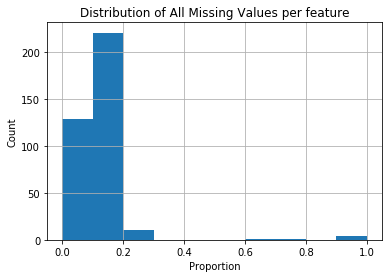

In [25]:
# Perform an missing data assessment per each feature of the current dataset.
nan_col = azdias.isnull().sum()/azdias.shape[0]

nan_col.sort_values(ascending = False).hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per feature');

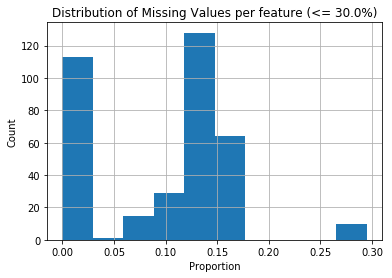

In [26]:
# Deeply analyze missing data patterns of each column by threshold which can .
threshold_nan = 0.3
nan_col_sub = nan_col[nan_col <= threshold_nan]

nan_col_sub.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of Missing Values per feature (<= {}%)'.format(threshold_nan*100));

a. Based on the histogram of the distribution of All Missing Values per feature, we can see the distribution of the amount of missing data is skewed to the right. Most of the features have about 30% of missing data on the histogram; less of features have greater than 30% of missing data.

b. Based on the histogram of Distribution of Missing Values per feature(<=30%), it's a bimodel distribution and there are two  patterns: the first pattern is an almost single bar for no missing values; the second pattern has a slightly normal distribution for missing data < 30% but not equal to 0 and the features which are related have missing values with almost similar proportions.

In [329]:
# Remove the outlier features from the azdias dataset which can affect our model prediction. 
features_outlier = nan_col[nan_col > threshold_nan].index
azdias_sub = azdias.drop(features_outlier, axis=1)

# Show column outliers
features_outlier

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

The columns with missing values greater than 30% are:
* ALTER_KIND1 - No information
* ALTER_KIND2 - No information
* ALTER_KIND3 - No information
* ALTER_KIND4 - No information
* EXTSEL992 - No information
* KK_KUNDENTYP - No information

In [31]:
# Remove the outlier attributes from feature_df and make feature definition consistent
feature_df_new = feature_df[feature_df.index.isin(features_outlier) == False]
feature_df_new.shape

(360, 2)

#### 1.2: Choose and Encode Features
The most common unsupervised learning model is for cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data. Since the unsupervised learning techniques will only work on data that is encoded numerically, there are some cases need to to handled: 
First, a few encoding changes or additional assumptions will be made. 
Second, almost all of the values in the dataset are encoded using numbers and but not all of them represent numeric values. some values of feature still use characters. 
Last, the features dictionary will be checked for a summary of types of measurement.

After checking the azdias dataset, we need to focus on those things:

1) In the azdias dataset, there are types of some features which are unknown or string. They must be identified first and encorde them.

2) The features with numeric and interval data can be kept without changes.

3) Most of the variables in the dataset are ordinal in nature. The ordinal values may be non-linear technically in distribution space, we can make an assumption that the ordinal variables can be treated as being interval in nature. 

4) For the variable types: categorical and mixed-type, we need a special handling.


Based on the previous investigation, our implementation steps are like that:

First, the features which have unknown types will be examined and assumptions will be made.

Second, an investigation of the categorical and mixed-type features will be investigated and decide whether they will be kept, dropped, or re-encoded. 

Finally, in the last part, a new data frame will be created with only the selected and engineered columns.

In [32]:
#get all features datatypes
feature_df.info

<bound method DataFrame.info of                              type missing_or_unknown
attribute                                           
AGER_TYP              categorical                 -1
ALTERSKATEGORIE_GROB  categorical              -1, 0
ALTER_HH              categorical              -1, 0
ANREDE_KZ             categorical              -1, 0
ANZ_HAUSHALTE_AKTIV       numeric              -1, 0
...                           ...                ...
VHA                           NaN                 []
VHN                           NaN                 []
VK_DHT4A                      NaN                 []
VK_DISTANZ                    NaN                 []
VK_ZG11                       NaN                 []

[366 rows x 2 columns]>

In [33]:
# How many features are there of each data type?
feature_df['type'] = feature_df['type'].astype(str)
feature_df.groupby(['type']).count()

,missing_or_unknown
type,
categorical,71
nan,94
numeric,7
ordinal,194


From the previous list, there are 360 of ordinal and categorical and numerical features and 6 of string features.
According to our agreement, we need to keep those values.

In [282]:
for feat in feature_df_new[feature_df_new['type'].isnull()].index:
    print(azdias_sub[feat].value_counts())
    #azdias_sub[feat].value_counts().plot(kind='barh')

1.0    390258
9.0    270663
5.0     29203
6.0     27655
3.0     24880
4.0     21466
7.0     21026
8.0     17485
2.0     15086
Name: AKT_DAT_KL, dtype: int64
15.0    63486
14.0    59709
16.0    53384
18.0    51365
17.0    50011
13.0    49556
12.0    42951
19.0    42340
0.0     41188
10.0    34903
11.0    33061
20.0    27833
9.0     26204
8.0     14516
21.0    13658
7.0      8578
6.0      3754
22.0     3669
23.0     2838
24.0     2340
25.0     1017
5.0       994
4.0       636
3.0       218
2.0        64
1.0         1
Name: ALTERSKATEGORIE_FEIN, dtype: int64
0.0     731242
1.0      55350
2.0      24445
3.0       5376
4.0       1057
5.0        190
6.0         47
7.0         10
9.0          3
11.0         1
8.0          1
Name: ANZ_KINDER, dtype: int64
1.0      219119
2.0      121485
3.0       61478
4.0       44864
5.0       40133
          ...  
190.0         2
336.0         2
197.0         2
133.0         1
314.0         1
Name: ANZ_STATISTISCHE_HAUSHALTE, Length: 268, dtype: int64
4.0   

In [36]:
#LNR - This is unique for each row so it is not useful for machine learning.
azdias_sub['LNR'].value_counts()

192418    1
611455    1
982154    1
976009    1
978056    1
         ..
563128    1
585655    1
583606    1
589749    1
192606    1
Name: LNR, Length: 891221, dtype: int64

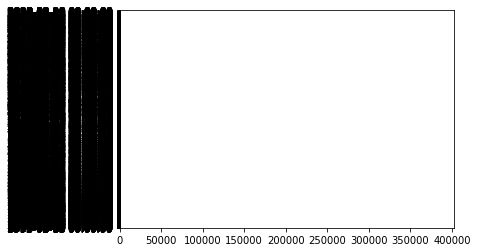

In [37]:
#This can be categorical but there are many levels which may not be captured accurately.
azdias_sub['EINGEFUEGT_AM'].value_counts().plot(kind='barh')

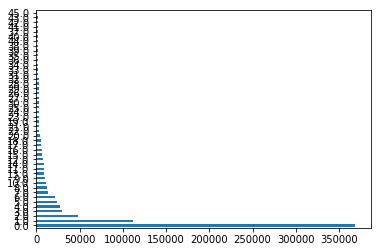

In [38]:
#This can also be categorical but there are many levels too.
azdias_sub['VERDICHTUNGSRAUM'].value_counts().plot(kind='barh')
#from that chart, we can see most of 'VERDICHTUNGSRAUM' values are 0.0 and so it's not good for data analysis.

In [34]:
#those features are not useful
feature_drop = ['LNR', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM']

There are three features which will be dropped:

* LNR - This is unique for each row so it is not useful for machine learning.
* EINGEFUEGT_AM - This can be categorical but there are many levels which may not be captured accurately.
* VERDICHTUNGSRAUM - This can also be categorical but there are many levels too.

In addition, they don't also exist in the DIAS Attributes - Values 2017.xls file so the solution is to drop them.

In [35]:
# Drop the three features
azdias_sub = azdias_sub.drop(feature_drop, axis=1)
feature_df_new = feature_df_new.drop(feature_drop, axis=0)
azdias_sub.shape[1], feature_df_new.shape[0] 

(357, 357)

In [36]:
features_numeric = ['ANZ_STATISTISCHE_HAUSHALTE']

features_ordinal = ['AKT_DAT_KL','ANZ_KINDER','CJT_KATALOGNUTZER','CJT_TYP_1','CJT_TYP_2','CJT_TYP_3','CJT_TYP_4','CJT_TYP_5','CJT_TYP_6',
'D19_KONSUMTYP_MAX','D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12','D19_VERSI_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM','D19_VERSI_ONLINE_QUOTE_12',
'DSL_FLAG','FIRMENDICHTE','HH_DELTA_FLAG','KBA13_ANTG1','KBA13_ANTG2','KBA13_ANTG3','KBA13_ANTG4','KBA13_BAUMAX','KBA13_GBZ',
'KBA13_HHZ','KBA13_KMH_210','KOMBIALTER','KONSUMZELLE','MOBI_RASTER','RT_KEIN_ANREIZ','RT_SCHNAEPPCHEN','RT_UEBERGROESSE','UMFELD_ALT',
'UMFELD_JUNG','UNGLEICHENN_FLAG','VHA','VHN','VK_DHT4A','VK_DISTANZ','VK_ZG11']

features_categorical = ['ALTERSKATEGORIE_FEIN','D19_LETZTER_KAUF_BRANCHE','EINGEZOGENAM_HH_JAHR','GEMEINDETYP','STRUKTURTYP']

In [37]:
# Fill the missing feature types
feature_df_new.loc[features_numeric , 'type'] = 'numeric'
feature_df_new.loc[features_ordinal, 'type'] = 'ordinal'
feature_df_new.loc[features_categorical, 'type'] = 'categorical'

##### 1.2.1 Convert NAN values for numerical/ordinal/categorical features(numeric)
For categorical data, 'NAN' values exist in lots of features. They need to convert to numeric value and then they can be applied to machine learning model for data analysis. 

* Numeric features: using 0 instead of 'nan' values
* Ordinal features: using 'Unknown' numeric values instead of 'nan' values
* Categorical features: using 'Unknown' numeric values instead of 'nan' values

In the feature_dict dictionary, there are some 'Unknow' values which contains two values(e.g. -1,9). we can use one of them. In my project, I'll use first value instead of 'nan'

In [38]:
#Assess string variables: which are not ordinal/numeric/categorical features
azdias_str = azdias_sub.select_dtypes(exclude=[np.number])
azdias_str.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,W
2,4C,4,24,D19_UNBEKANNT,W
3,2A,2,12,D19_UNBEKANNT,W
4,6B,6,43,D19_SCHUHE,W


In [39]:
#the features which contains string values 
features_str = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE']

In [40]:
#feature_df_new.loc('AGER_TYP')['type']
feature_df_new.at['AKT_DAT_KL','type']

'ordinal'

In [41]:
#convert all categoryies nan for ordinal/numeric/categorical features
def convert_all_defined_features(conver_cols, convert_matrix):
    """
    This function is to convert all values of feature array
    The parameters: "conver_cols" contains all column names of features.
                    "convert_matrix" is data matrix.
    """
    for each_col in conver_cols:  # Convert by each column
        each_data = convert_matrix[each_col]  # Get each column data
           
        convert_matrix[each_col] = each_data.astype(str)  # convert directly
        
        feature_type = feature_df.at[each_col,'type']
        if(feature_type == 'numeric'):
            convert_matrix[each_col] = convert_matrix[each_col].replace('nan', 0)
        else:
            if each_col in feature_dict:            
                #Replace all 'nan' value by its feature definitions or convert them to 0 if feature is not in feature dictionary
                feature_def = feature_dict[each_col]
                if 'unknown' in feature_def:
                    convert_matrix[each_col] = convert_matrix[each_col].replace('NaN', feature_def['unknown']) 
                else:
                    convert_matrix[each_col] = convert_matrix[each_col].replace('NaN', 0)
            else:
                convert_matrix[each_col] = convert_matrix[each_col].replace('NaN', 0)          

In [290]:
#convert ‘nan’ values of other features into a speical value based on its definitions
#features_list = set(azdias_sub.columns) - set(features_str)
#convert_all_defined_features(features_list, azdias_sub)

In [42]:
azdias_sub.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


##### 1.2.2 Convert values for categorical features(string)
There are two string category features:'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'. Their values can't be analyzed directly. we need to convert them based on their definition in feature_dict dictionary. 

* using 'Unknown' numeric values instead of 'nan' values

In [43]:
#string category feature list
features_str

['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']

In [44]:
#check 'CAMEO_DEU_2015' feature category definition
feature_dict['CAMEO_DEU_2015']
#its defintion is like that: {'categorical': 9, nan: 6} 

{'categorical': 9, nan: 6}

In [45]:
#So this category definition can't be used 

In [31]:
#this function is to convert all string category features
def convert_all_str_features(conver_cols, convert_matrix):
    """
    This function is to convert all values of feature array
    The parameters: "conver_cols" contains all column names of features.
                    "convert_matrix" is data matrix.
    """
    for each_col in conver_cols:  # Convert by each column
        each_data = convert_matrix[each_col]  # Get each column data
        
        convert_matrix[each_col] = each_data.astype(str)

        model_le = LabelEncoder()  # Builde model objects    
        each_con_data = model_le.fit_transform(each_data.astype(str))  # convert directly

        convert_matrix[each_col] = each_con_data  # Replace the original value with the converted value
        #convert_matrix[each_col] = convert_matrix[each_col].replace('NaN', 0) #Replace all 'nan' value to 0
    return convert_matrix

In [47]:
#convert str categories to numeric values and set nan to 0
azdias_sub = convert_all_str_features(features_str, azdias_sub)

In [48]:
azdias_sub['CAMEO_DEU_2015']


0         45
1         35
2         15
3          5
4         25
          ..
891216    30
891217    42
891218    15
891219    42
891220    25
Name: CAMEO_DEU_2015, Length: 891221, dtype: int32

##### 1.2.3: Re-Encode Categorical Features
For categorical data, levels will be encoded as dummy variables. Depending on the number of categories, one of the following will be performed

* For binary (two-level) categoricals that take numeric values, they will be kept without needing to do anything.
* There is one binary variable that takes on non-numeric values. For this one, the values will be re-encoded as numbers.
* For multi-level categoricals (three or more values), the values will be encoded using multiple dummy variables.

In [49]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
categorical = feature_df_new[feature_df_new['type'] == 'categorical']
categorical

,type,missing_or_unknown
attribute,,
AGER_TYP,categorical,-1
ALTERSKATEGORIE_GROB,categorical,"-1, 0"
ALTER_HH,categorical,"-1, 0"
ANREDE_KZ,categorical,"-1, 0"
BALLRAUM,categorical,-1
CAMEO_DEUG_2015,categorical,-1
CAMEO_DEU_2015,categorical,-1
CJT_GESAMTTYP,categorical,0
D19_BANKEN_DATUM,categorical,0


In [50]:
# Check categorical variable whether it is binary or multi-level
binary_category_features = []
multi_category_features = []
for feat in categorical.index:
    if len(azdias_sub[feat].value_counts()) == 2:
        binary_category_features.append(feat)
    else:
        multi_category_features.append(feat)
print('There are {} binary features in total.'.format(len(binary_category_features)))
print('There are {} multi-level features in total.'.format(len(multi_category_features)))

There are 3 binary features in total.
There are 73 multi-level features in total.


In [51]:
 #check binary feature values
for feat_name in list(binary_category_features):    
    print(azdias_sub[feat_name].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [52]:
#based on previous result, the feature 'OST_WEST_KZ' need to be converted to numeric
azdias_sub['OST_WEST_KZ'] = azdias_sub['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
print(azdias_sub['OST_WEST_KZ'].value_counts())

2.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64


In [53]:
# Re-encode binary features to be kept in analysis using one-hot encoding.
azdias_encode = pd.get_dummies(azdias_sub, columns=binary_category_features)

In [54]:
# Re-encode multi-category features to be kept in analysis using one-hot encoding.
azdias_encode = pd.get_dummies(azdias_encode, columns=multi_category_features)

In [55]:
azdias_encode.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,CAMEO_INTL_2015,CJT_KATALOGNUTZER,...,GEMEINDETYP_11.0,GEMEINDETYP_12.0,GEMEINDETYP_21.0,GEMEINDETYP_22.0,GEMEINDETYP_30.0,GEMEINDETYP_40.0,GEMEINDETYP_50.0,STRUKTURTYP_1.0,STRUKTURTYP_2.0,STRUKTURTYP_3.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,0,0,0,0,0,0,0,0,0,0
1,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,51,1.0,...,0,0,0,1,0,0,0,0,1,0
2,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,24,2.0,...,0,0,0,1,0,0,0,0,0,1
3,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,12,3.0,...,0,0,0,0,0,1,0,1,0,0
4,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,43,3.0,...,0,0,1,0,0,0,0,0,0,1


Re-Encode Categorical Features

* The binary features have different binary numeric values and so re-encoding has the benefit of not weighting a value improperly. 
* The rest of the multi-category features were re-encoded using one-hot-encoding through the use of the pd.get_dummies function from pandas. The number of columns will increase due to the additional columns created by the one-hot-encoding step.

##### 1.2.4 Assess Undifined Features
In the dataset, some features are without its definition. we need to clean up them. 
CAMEO_INTL_2015 - it contains numeric and strinng values and but its definition doesn’t exists in feature definition file.

In [56]:
azdias['CAMEO_INTL_2015'].value_counts().sort_values()

XX        373
33.0     4102
35.0     4266
32.0     4287
12.0     5604
33       5833
32       6067
35       6090
44.0     6277
15.0     7142
12       7645
34.0     7787
31.0     7983
44       8543
52.0     8706
15       9832
55.0    10113
34      10737
45.0    10926
31      11041
13.0    11064
23.0    11097
52      11836
55      13842
22.0    13982
45      15206
13      15272
23      15653
25.0    16791
22      19173
54.0    19184
25      22837
43.0    23942
54      26207
14.0    26360
43      32730
14      36524
24.0    38276
41.0    38877
24      52882
41      53459
51.0    56118
51      77576
Name: CAMEO_INTL_2015, dtype: int64

In [57]:
azdias_encode = azdias_encode.drop('CAMEO_INTL_2015', axis = 1)
feature_df_new = feature_df_new.drop('CAMEO_INTL_2015', axis = 0)

In [58]:
azdias_clean = azdias_encode.copy()

In [59]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 987 entries, AKT_DAT_KL to STRUKTURTYP_3.0
dtypes: float64(211), int64(69), uint8(707)
memory usage: 2.4 GB


In [60]:
set(feature_df_new[feature_df_new['type'] == 'categorical'].index)

{'AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'EINGEZOGENAM_HH_JAHR',
 'EWDICHTE',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'INNENSTADT',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'KBA05_HERSTTEMP',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_M

#### 1.2.5 Build Clean-up Function to clean up azdias dataset

In [32]:
def cleanup_dataset(df):
    """
    Perform feature trimming, re-encoding, and engineering for feature data
    
    INPUT: Feature DataFrame
    OUTPUT: Trimmed and cleaned feature DataFrame
    """
    #copy original dataset
    df_clone = df.copy()
    # Put in code here to execute all main cleaning steps:
    
    # change to float for the other three datasets and convert missing value into unknow numeric value
    #the features which contains string values 
    str_feats = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE']
    convert_all_str_features(str_feats, df_clone)
    
    # convert missing value codes into NaNs, ...
    #category_features_list = set(df_clone.columns) - set(str_feats)
    #convert_all_defined_features(category_features_list, df_clone)
                
    # remove selected columns and rows, ...
    col_outlier = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP']
    df_sub = df_clone.drop(col_outlier, axis=1)
    
    # drop unuseful features
    df_sub = df_sub.drop(['LNR', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM'], axis=1)
    
    # select, re-encode, and engineer column values.
    df_sub['OST_WEST_KZ'] = df_sub['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    
    
    categorical = ['AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'EINGEZOGENAM_HH_JAHR',
 'EWDICHTE',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'INNENSTADT',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'KBA05_HERSTTEMP',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MODTEMP',
 'KBA05_SEG6',
 'KBA13_MOTOR',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'NATIONALITAET_KZ',
 'ORTSGR_KLS9',
 'OST_WEST_KZ',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'PRAEGENDE_JUGENDJAHRE',
 'REGIOTYP',
 'RETOURTYP_BK_S',
 'SHOPPER_TYP',
 'STRUKTURTYP',
 'TITEL_KZ',
 'VERS_TYP',
 'WOHNDAUER_2008',
 'WOHNLAGE',
 'W_KEIT_KIND_HH',
 'ZABEOTYP']
    
    df_converted = pd.get_dummies(df_sub, columns=categorical)
    
    
    # drop unuseful features
    df_clean = df_converted.drop(['CAMEO_INTL_2015'], axis=1)

    # Return the cleaned dataframe.
    return df_clean

In [33]:
azdias_clone = cleanup_dataset(azdias)

### 2 Feature Transformation
Feature transformation involves mapping a set of values for the feature to a new set of values to make the representation of the data more suitable or easier to process for the downstream analysis. A common feature transformation operation is a scaling.

#### 2.1 Apply Feature Scaling

Before dimensionality reduction techniques are applied to the data, feature scaling must be performed so that the principal component vectors are not influenced by the natural differences in scale for features. 

* `sklearn` requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, the DataFrame must be cleaned of the remaining missing values before applying the scaler. This was done by applying an Imputer to replace all missing values. 
* For the actual scaling function, a StandardScaler instance was done, scaling each feature to mean 0 and standard deviation 1.
* For these classes, the .fit_transform() method was used to both fit a procedure to the data as well as apply the transformation to the data at the same time. 

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
azdias_null = azdias_clone[azdias_clone.isnull().any(axis=1)] # subset of missing data

# Compare shape between `azdias_clone` and its subset of missing data
(azdias_clone.shape, azdias_null.shape)

((891221, 974), (349223, 974))

In [35]:
# Apply `Imputer` to replace all missing values with the mean
imputer = Imputer()
azdias_impute = imputer.fit_transform(azdias_clone)

E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# Apply `SimpleImputer` to replace all missing values with the median
azdias_impute1 = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_impute1.fit(azdias_clone)

In [36]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_impute)

In [37]:
azdias_scaled.shape

(891221, 974)

Apply Feature Scaling: There are 349223 records with missing values which is about 39% of 891221 records and they should not be dropped. So, there are several ways to handle missing value:
* all missing values were replaced using 'unknown' value per feature if there are missing values.
* all missing values were replaced by the mean value which is provided by Imputer along all features(columns) of dataset if there are missing values.

Then the Feature scaling is applied by StandardScaler instance of sklearn and its '.fit_transform()' method fits to the data and transform it at the same time. The StandardScaler instance returns an array list for the next step Performance Dimentionality Reduction - PCA.

#### 2.2 Perform Dimensionality Reduction
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables. It can be divided into feature selection and feature extraction.

* Sklearn PCA model will handle principal component analysis on the data, thus find the vectors of maximal variance in the data. 
* The ratio of variance explained by each principal component as well as the cumulative variance explained will be checked by plotting the cumulative or sequential values using matplotlib's plot() function. 
* PCA model will be re-fit to perform the decided-on transformation.

In [330]:
# Apply PCA to the data.
components_num = int(azdias_impute.shape[1] / 2) # Half the number of features

pca = PCA(components_num)
azdias_pca = pca.fit_transform(azdias_scaled)

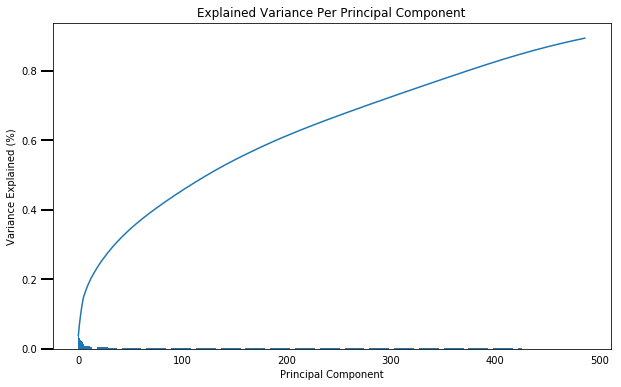

In [331]:
# Analyze the variance ratio for by each principal component.
ind = np.arange(components_num)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(components_num):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [41]:
# Re-apply PCA to the data and check the variance ratio of components
sum(pca.explained_variance_ratio_)
#when using "unknown" value instead of messing values, its explained variance is 0.8955750104090971
#when using mean instead of missing values, its explained variance is 0.8932687682414621


0.8932687682414621

Perform Dimensionality Reduction
* As analyzed by PCA, 50% of features (487 out of 974) was used as the initial number of components for the principal component analysis of the data. The 487 components can explain about 89.33% of the variability in the original dataset. This is good enough for further analysis and no further re-application is necesssary.

#### 2.3 Interpret the key results for Principal Components Analysis
Principal components analysis is based on the correlation matrix of the variables involved, and correlations usually need a large sample size before they stabilize. The principal components have been transformed and the weight of each variable on the first few components should be checked if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components),which are correlated. The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, each weight should be mapped to their corresponding feature name, then the features should be sorted according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 

In [332]:
# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# Create component datafrom from PCA components and keep 6 digital of weight
components = pd.DataFrame(np.round(pca.components_, 6), columns = azdias_clone.keys())
components.index = dimensions

In [333]:
components.shape

(487, 974)

In [334]:
#The first principal component to corresponding feature names(sorted by weight).
components.iloc[0].sort_values(ascending=False)

D19_KONSUMTYP_MAX       0.104790
VK_DHT4A                0.101720
D19_VERSAND_DATUM_10    0.099802
VK_DISTANZ              0.097636
D19_GESAMT_DATUM_10     0.096617
                          ...   
PLZ8_BAUMAX_1.0        -0.099837
LP_STATUS_FEIN         -0.099908
LP_STATUS_GROB         -0.100237
D19_GESAMT_ANZ_24      -0.104778
MOBI_REGIO             -0.107389
Name: Dimension 1, Length: 974, dtype: float64

##### Dimension 1:(display top 5 features)

* D19_KONSUMTYP_MAX (0.1048) - consumption type
* VK_DHT4A (0.1017) - no information
* D19_VERSAND_DATUM_10 (0.0998) - actuality of the last transaction for the segment mail-order TOTAL
* VK_DISTANZ (-0.0976) - no information
* D19_GESAMT_DATUM_10 (-0.0966) - actuality of the last transaction with the complete file TOTAL

Interpretation: The first principal component is strongly correlated with consumption type to ‘none’(VK_DHT4A). D19_VERSAND_DATUM_10 is described in the attributes file but it can be related to consumption type. Higher consumption and no transactions known tend to negatively affect this first principal component.

In [45]:
#The second principal component to corresponding feature names(sorted by weight).
components.iloc[1].sort_values(ascending=False)

KBA05_MAXAH_9.0       0.1641
KBA05_SEG6_9.0        0.1641
KBA05_MAXBJ_9.0       0.1641
KBA05_MAXHERST_9.0    0.1641
KBA05_MAXSEG_9.0      0.1641
                       ...  
FINANZ_SPARER        -0.0406
KBA13_ANTG3          -0.0413
PLZ8_ANTG3           -0.0413
KBA05_ANHANG_0.0     -0.0511
KBA05_SEG6_0.0       -0.0543
Name: Dimension 2, Length: 974, dtype: float64

##### Dimension 2:(display top 5 features)

* KBA05_MAXAH_9.0       0.1641 - most common age of car owners in the microcell(unknown)
* KBA05_SEG6_9.0        0.1641 - share of upper class cars (BMW 7er etc.) in the microcell(unknown)
* KBA05_MAXBJ_9.0       0.1641 - most common age of the cars in the microcell(unknown)
* KBA05_MAXHERST_9.0    0.1641 - most common car manufacturer in the microcell(unknown)
* KBA05_MAXSEG_9.0      0.1641 - most common car segment in the microcell(unknown)

Interpretation: The second principal component is strongly correlated with most common age of car owners in the microcell and share of upper class cars (BMW 7er etc.) in the microcell and most common age of the cars in the microcell and most common car manufacturer in the microcell and most common car segment in the microcell. They tend to negatively affect this second principal component.

### 3 Clustering
#### 3.1 Apply Clustering to General Population
Now, it's time to see how the data clusters in the principal components space. In this substep, k-means clustering will be applied to the dataset and the average within-cluster distances from each point to their assigned cluster's centroid will be used to decide on a number of clusters to keep.

* sklearn's KMeans class will be used to perform k-means clustering on the PCA-transformed data.
* Then, the average difference from each point to its assigned cluster's center will be computed.
* The above two steps will be performed for a 30 different cluster counts to see how the average distance decreases with an increasing number of clusters. 
* Once final number of clusters to use is selected, KMeans instance will be re-fit to perform the clustering operation.

In [335]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [59]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
centers = list(range(1,30,3))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

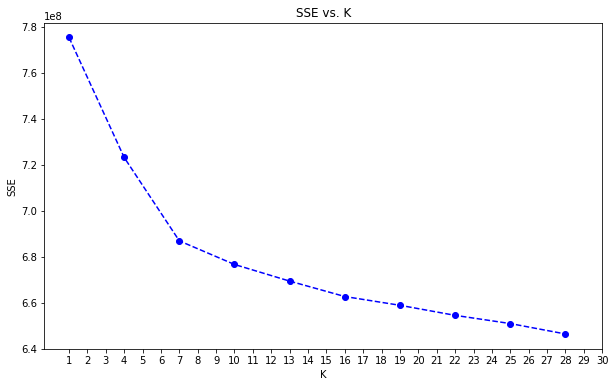

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=30, random_state=42, n_jobs=-1)
azdias_preds = kmeans.fit_predict(azdias_pca)

In [62]:
azdias_cluster = pd.DataFrame(np.round(azdias_pca, 4), columns = dimensions)
azdias_cluster.insert(loc=0, column='Cluster', value=azdias_preds)
azdias_cluster.head()

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 478,Dimension 479,Dimension 480,Dimension 481,Dimension 482,Dimension 483,Dimension 484,Dimension 485,Dimension 486,Dimension 487
0,15,5.4174,-0.0533,-7.3471,-4.9238,-0.0639,6.2279,-0.1465,1.0518,-0.7074,...,-0.1535,0.2201,0.2812,0.2053,-0.0306,0.0041,-0.2636,0.3133,-0.2561,-0.0481
1,7,4.8199,-3.0586,2.4784,-4.4042,4.7708,-5.0419,-0.6097,-3.0868,2.8947,...,-1.9819,0.0165,0.7985,-0.9285,0.4532,0.5320,-0.4813,0.2622,-0.3971,-0.6104
2,0,-0.0878,-0.7712,-1.5399,-0.8967,4.1177,-6.0043,3.6901,-6.1616,-2.3173,...,0.0908,-0.7025,-0.6634,-0.8549,0.3988,0.7259,-0.9186,1.2170,-0.6666,-0.4520
3,13,-3.2697,2.5374,-7.5715,1.6206,-0.1325,-2.5768,-0.9088,-0.9659,2.5007,...,-0.4874,-0.2918,0.2568,0.6612,0.7818,-0.5269,0.5636,-0.8835,0.1224,-0.3870
4,6,-7.5061,0.1109,9.0673,-0.0271,2.5184,6.1751,-4.1544,1.5003,-1.8220,...,-1.2111,0.2218,1.3160,1.1552,-1.4061,1.6243,-0.2093,0.4342,0.8188,-0.4178


##### Apply KMeans Clustering to General Population
using KMeans class is to perform k-means clustering on the PCA-transformed data for a number of different cluster counts. It can reduce the computation time and attempt to optimise the same objective function. In practice this difference in quality can be quite small. But the KMeans algorithm can not resolve big dataset.

The scree plot shows that the score or the sum of the squared errors (SSE) generally decreased as the number of clusters increased. As the instruction suggested, the maximum clusters used was 30. The 'elbow method' is not applicable in the plot because there is no visible leveling observed. Even though 30 clusters did not produce the lowest SSE, it was still used as the number of clusters for the full KMeans clustering operation.

#### 3.2 Apply All Steps to the Customer Data
The clusters and cluster centers for the general population have been obtained and now we make the customer data map on to those clusters. The fits from the general population will be used to clean up, transform, and cluster the customer data. In the last step, there will be an interperation on how the general population fits apply to the customer data.

In [92]:
# This is to set the object type since these two columns are mixed type
dtypes = {"CAMEO_DEUG_2015": object, "CAMEO_INTL_2015": object}

In [93]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', dtype=dtypes)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [94]:
customers_train = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
print(customers_train.shape)
customers_train.head()

(191652, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [95]:
# Apply preprocessing onto the customer data
customers_clean = cleanup_dataset(customers_train)

In [96]:
# Check if there are missing columns in `customers_clean` dataset
customer_missing = list(np.setdiff1d(azdias_clone.columns, customers_clean.columns))
customer_missing

['ALTERSKATEGORIE_FEIN_1.0',
 'ALTER_HH_1.0',
 'D19_BANKEN_ONLINE_QUOTE_12_1.0',
 'EINGEZOGENAM_HH_JAHR_1900.0',
 'EINGEZOGENAM_HH_JAHR_1904.0',
 'EINGEZOGENAM_HH_JAHR_1971.0',
 'EINGEZOGENAM_HH_JAHR_1984.0',
 'GEBAEUDETYP_5.0',
 'ORTSGR_KLS9_0.0',
 'TITEL_KZ_2.0']

In [97]:
# Add the missing column with default value of 0
for m in customer_missing:
    customers_clean[m] = 0
    customers_clean[m] = customers_clean[m].astype('uint8')
    
print(customers_clean.shape)
customers_clean.head()

(191652, 975)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,CJT_KATALOGNUTZER,CJT_TYP_1,...,ALTERSKATEGORIE_FEIN_1.0,ALTER_HH_1.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,EINGEZOGENAM_HH_JAHR_1900.0,EINGEZOGENAM_HH_JAHR_1904.0,EINGEZOGENAM_HH_JAHR_1971.0,EINGEZOGENAM_HH_JAHR_1984.0,GEBAEUDETYP_5.0,ORTSGR_KLS9_0.0,TITEL_KZ_2.0
0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,9.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,5.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,5.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
customers_clean.isnull().sum()

AKT_DAT_KL                     46596
ANZ_HAUSHALTE_AKTIV            49927
ANZ_HH_TITEL                   52110
ANZ_KINDER                     46596
ANZ_PERSONEN                   46596
                               ...  
EINGEZOGENAM_HH_JAHR_1971.0        0
EINGEZOGENAM_HH_JAHR_1984.0        0
GEBAEUDETYP_5.0                    0
ORTSGR_KLS9_0.0                    0
TITEL_KZ_2.0                       0
Length: 974, dtype: int64

In [143]:
customers_clean.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,CJT_KATALOGNUTZER,CJT_TYP_1,...,ALTERSKATEGORIE_FEIN_1.0,ALTER_HH_1.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,EINGEZOGENAM_HH_JAHR_1900.0,EINGEZOGENAM_HH_JAHR_1904.0,EINGEZOGENAM_HH_JAHR_1971.0,EINGEZOGENAM_HH_JAHR_1984.0,GEBAEUDETYP_5.0,ORTSGR_KLS9_0.0,TITEL_KZ_2.0
0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,9.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,5.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,5.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Check if there are additional columns in `customers_clean` dataset
customer_addition = list(np.setdiff1d(customers_clean.columns, azdias_clone.columns))
customer_addition

['KBA05_GBZ_0.0']

In [101]:
customers_clean['KBA05_GBZ_0.0']

0         0
1         0
2         0
3         0
4         0
         ..
191647    0
191648    0
191649    0
191650    0
191651    0
Name: KBA05_GBZ_0.0, Length: 191652, dtype: uint8

In [102]:
# Drop the additional columns in `customers_clean` dataset
customers_clean = customers_clean.drop(['KBA05_GBZ_0.0'], axis=1)

In [162]:
# Apply feature transformation and cluster from the general demographics to the customer data  
# and obtain cluster predictions for the customer demographics data.

customers_impute = imputer.transform(customers_clean)
customers_scaled = scaler.fit_transform(customers_impute)
customers_pca = pca.fit_transform(customers_scaled)
customers_preds = kmeans.predict(customers_pca)

In [163]:
customers_cluster = pd.DataFrame(np.round(customers_pca, 4), columns = dimensions)
customers_cluster.insert(loc=0, column='Cluster', value=customers_preds)
customers_cluster.head()

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 478,Dimension 479,Dimension 480,Dimension 481,Dimension 482,Dimension 483,Dimension 484,Dimension 485,Dimension 486,Dimension 487
0,14,-6.3553,-0.4769,4.6599,-8.2142,-3.1315,1.9501,0.9789,-3.1789,0.6125,...,0.0735,0.3598,0.5570,-0.2014,0.5458,-0.2893,0.6356,-0.7306,0.6033,-0.0150
1,2,2.5633,0.1953,-0.4678,1.0125,-0.9779,0.4852,-0.3542,-0.4355,2.3459,...,-0.2379,-0.5907,-0.5686,-0.3231,0.8127,0.3235,-0.1848,-0.2437,0.1362,0.2973
2,14,0.3920,8.3190,0.9019,-1.5511,-3.6255,1.0274,-0.7343,-4.9834,-2.8636,...,0.1737,-0.2770,-0.5024,0.0450,0.6540,1.6161,-1.0787,1.4305,0.7963,-0.7681
3,14,-2.6499,-2.6513,0.8252,-3.2274,-5.5142,2.1446,2.1058,3.1931,2.4871,...,-0.4842,-0.2160,0.1034,-1.4237,-1.0401,0.6933,-0.8538,0.8791,0.5894,0.2560
4,1,-4.0646,-0.9454,-7.0866,10.5227,4.0562,-1.7458,0.1218,-5.1292,-2.4429,...,-1.7181,1.2759,0.3676,-0.8288,1.1464,-0.5115,-0.3092,0.6168,-0.6954,1.5727


In [164]:
customers_cluster.shape

(191652, 488)

#### 3.3 Compare Customer Data to Demographics Data
The clustered data is based on demographics of the general population of Germany, and the customer dataset which is from a mail-order sales company has already been mapped to those demographic clusters. At the end, the distributions of these two clusters will be compared to check where the real customer group for the company is.

In [325]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def show_proportion(df_cluster, title='Default Title'):    
    #get order of bars by frequency
    cluster_counts = df_cluster['Cluster'].value_counts()
    cluster_order = cluster_counts.index

    #compute largest proportion
    n_model = df_cluster.shape[0]
    max_cluster_count = cluster_counts.iloc[0]
    max_prop = max_cluster_count / n_model

    #establish tick locations and create plot
    base_color = sns.color_palette()[0]
    tick_props = np.arange(0, max_prop, 0.02)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    base_color = sns.color_palette()[0]
    sns.countplot(data=df_cluster, y='Cluster', color=base_color, order=cluster_order)
    plt.xticks(tick_props * n_model, tick_names)
    plt.xlabel('proportion')
    plt.title(title);

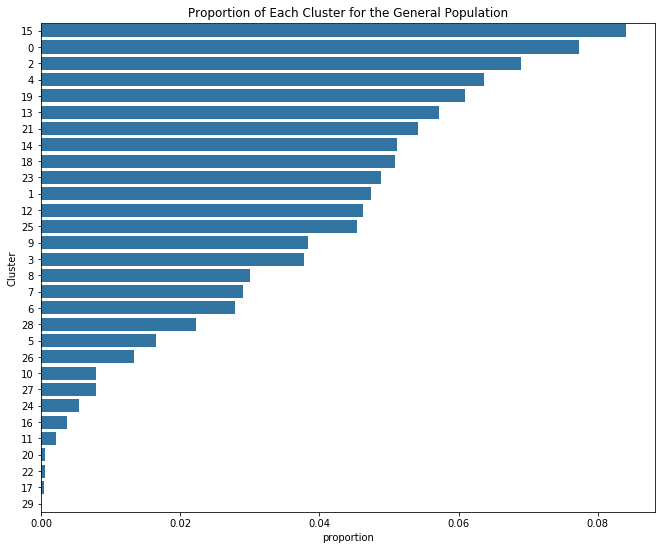

In [166]:
fig, ax = plt.subplots(figsize=(11,9))
show_proportion(azdias_cluster, title='Proportion of Each Cluster for the General Population')

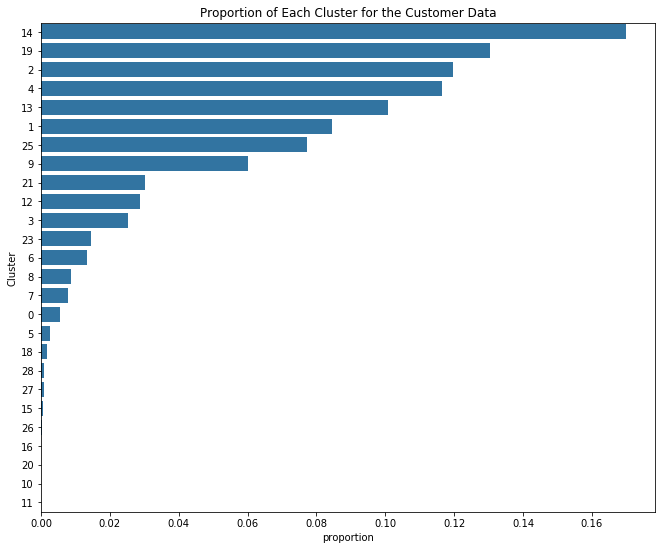

In [167]:
fig, ax = plt.subplots(figsize=(11,9))
show_proportion(customers_cluster, title='Proportion of Each Cluster for the Customer Data')

In [168]:
# Check for overrepresentation and underrepresentation of clusters between the two datasets
azdias_prop = azdias_cluster['Cluster'].value_counts() / azdias_cluster.shape[0]
customers_prop = customers_cluster['Cluster'].value_counts() / customers_cluster.shape[0]
diff_prop = customers_prop - azdias_prop

max_index = diff_prop.sort_values(ascending=False).index[0]
max_diff = diff_prop.sort_values(ascending=False).iloc[0]
min_index = diff_prop.sort_values(ascending=False).index[-6]
min_diff = diff_prop.sort_values(ascending=False).iloc[-6]

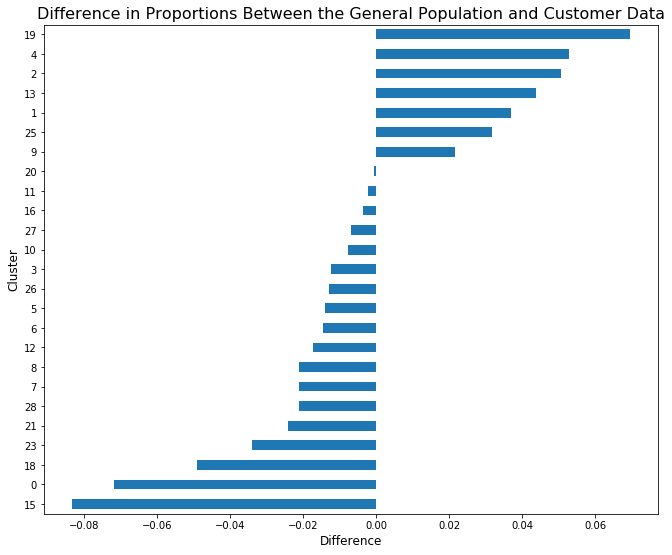

In [169]:
fig, ax = plt.subplots(figsize=(11,9))
diff_prop.sort_values()[:25].plot.barh(color=sns.color_palette()[0])
plt.title("Difference in Proportions Between the General Population and Customer Data", fontsize=16)
plt.xlabel("Difference", fontsize=12)
plt.ylabel("Cluster", fontsize=12);

In [170]:
# Function to transform centroids back to the original data space based on cluster number
def infer_cluster(index):
    
    # Subset the customers_cluster dataframe by the selected index
    cluster = customers_cluster[customers_cluster['Cluster'] == index]
    cluster_drop = cluster.drop('Cluster', axis=1)
    
    # Perform inverse PCA and inverse scaling to return to the original values
    cluster_pca = pca.inverse_transform(cluster_drop)
    cluster_scaler = scaler.inverse_transform(cluster_pca)
    
    # Create a new dataframe of the cluster and reuse the feature columns
    cluster_final = pd.DataFrame(cluster_scaler, columns=customers_clean.columns)
    return cluster_final

In [180]:
# infer Columns based on PCA feature analysis and choose some interesting features
infer_columns = ['D19_KONSUMTYP_MAX'
,'VK_DHT4A'
,'D19_VERSAND_DATUM_10'
,'VK_DISTANZ'
,'D19_GESAMT_DATUM_10'
]

In [181]:
# What kinds of person are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print('The cluster, which is the most overrepresented, is cluster {} with a difference of {}.'
         .format(max_index, np.round(max_diff, 4)))

The cluster which is the most overrepresented is cluster 14 with a difference of 0.1186.


In [182]:
over_cluster = infer_cluster(max_index)
print(over_cluster.shape)
over_cluster.head()

(32530, 974)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,CJT_KATALOGNUTZER,CJT_TYP_1,...,ALTERSKATEGORIE_FEIN_1.0,ALTER_HH_1.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,EINGEZOGENAM_HH_JAHR_1900.0,EINGEZOGENAM_HH_JAHR_1904.0,EINGEZOGENAM_HH_JAHR_1971.0,EINGEZOGENAM_HH_JAHR_1984.0,GEBAEUDETYP_5.0,ORTSGR_KLS9_0.0,TITEL_KZ_2.0
0,0.818137,2.425340,0.035482,-0.011200,1.992632,1.954511,0.017721,0.948977,4.685332,0.737191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.439897,-1.288730,0.024041,0.063153,1.012871,-0.441076,-0.050101,2.933188,4.740511,1.803718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.629115,0.038791,0.030279,0.015855,-0.560045,0.898360,0.002220,1.998648,5.210173,1.150066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.085725,-0.852371,-0.069118,0.036844,1.977657,-1.128764,0.068266,2.897199,3.533048,1.218905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.510388,-0.255511,0.031056,0.071286,1.991504,-0.202044,0.008861,1.643551,3.833667,1.032222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
over_cluster[infer_columns].describe()

,D19_KONSUMTYP_MAX,VK_DHT4A,D19_VERSAND_DATUM_10,VK_DISTANZ,D19_GESAMT_DATUM_10
count,32530.000000,32530.000000,32530.000000,32530.000000,32530.000000
mean,2.507703,4.232023,0.173434,4.056537,0.088683
std,1.561806,2.406304,0.336097,2.449339,0.221813
min,-0.605831,-1.170128,-0.359999,-1.933390,-0.447729
25%,1.756724,2.323676,-0.072551,1.967944,-0.054154
50%,2.134696,3.809174,0.084655,3.781737,0.033516
75%,2.555618,5.921061,0.254773,5.638149,0.153647
max,10.049183,13.170824,1.134389,13.238206,0.872833


In [184]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print('The cluster which is the most underrepresented is cluster {} with a difference of {}.'
         .format(min_index, np.round(min_diff, 4)))

The cluster which is the most underrepresented is cluster 0 with a difference of -0.0718.


In [185]:
under_cluster = infer_cluster(min_index)
print(under_cluster.shape)
under_cluster.head()

(1046, 974)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,CJT_KATALOGNUTZER,CJT_TYP_1,...,ALTERSKATEGORIE_FEIN_1.0,ALTER_HH_1.0,D19_BANKEN_ONLINE_QUOTE_12_1.0,EINGEZOGENAM_HH_JAHR_1900.0,EINGEZOGENAM_HH_JAHR_1904.0,EINGEZOGENAM_HH_JAHR_1971.0,EINGEZOGENAM_HH_JAHR_1984.0,GEBAEUDETYP_5.0,ORTSGR_KLS9_0.0,TITEL_KZ_2.0
0,0.958637,7.780902,0.010245,0.259717,3.234606,7.244246,-0.019355,3.223274,3.749338,1.184816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.139180,6.918319,-0.005139,0.117229,4.913436,6.140634,0.058822,3.191056,4.329029,1.556458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.943151,1.339920,0.090098,-0.122619,2.551631,1.532296,0.022248,3.530032,1.915900,2.456665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.484334,6.829854,-0.040308,0.082982,4.641099,6.274975,0.001694,3.040781,3.688680,1.658672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.079662,8.695668,0.014851,0.034898,1.020193,8.050013,0.001423,3.189359,3.447564,1.808676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
under_cluster[infer_columns].describe()

,D19_KONSUMTYP_MAX,VK_DHT4A,D19_VERSAND_DATUM_10,VK_DISTANZ,D19_GESAMT_DATUM_10
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,2.873194,4.370727,0.268920,4.345398,0.187734
std,1.606265,2.761880,0.388738,2.741324,0.262169
min,0.618650,-0.542018,-0.342192,-0.633534,-0.276202
25%,2.001258,2.091916,-0.044043,2.072065,0.003851
50%,2.448138,3.907934,0.148571,3.766708,0.109789
75%,3.110271,6.422330,0.626653,6.202298,0.314272
max,9.171527,12.784604,1.083974,13.262838,0.844630


In [324]:
# Compare the differences between the Potential and Non-Potential customer groups
over_mean = over_cluster[infer_columns].describe().loc['mean']
under_mean = under_cluster[infer_columns].describe().loc['mean']
mean_df = pd.concat([over_mean, under_mean], axis=1)
mean_df.columns = ['Potential Customer', 'Non-Potential Customer']

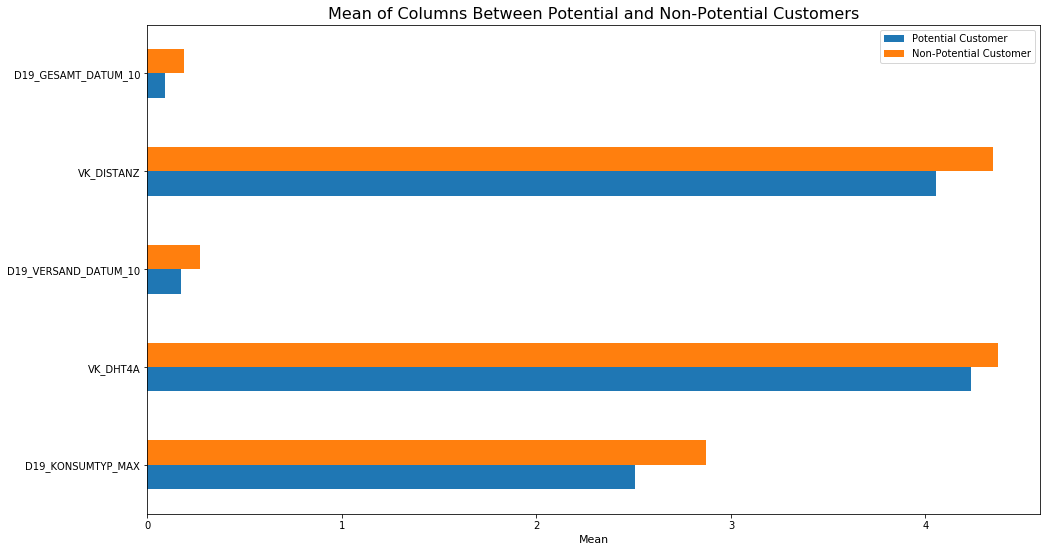

In [323]:
# Display the mean of the interesting columns for the Potential and Non-Potential customer groups
fig, ax = plt.subplots(figsize=(16,9))
plt.title("Mean of Columns Between Potential and Non-Potential Customers", fontsize=16)
plt.xlabel("Mean", fontsize=11)
mean_df.plot.barh(ax=ax);

##### Compare Customer Data to Demographics Data
Since there are over 900 features, it's impractical to check all features to interpret the two clusters. Based on the previous principal component interpretations, the columns ('D19_KONSUMTYP_MAX','VK_DHT4A','D19_VERSAND_DATUM_10','VK_DISTANZ','D19_GESAMT_DATUM_10') to be interpreted on the original data of the chosen clusters can be identified.
The target customers make transactions by other ways('no transactions known').

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [192]:
mailout_train.head()

E:\Anaconda3_W12\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [194]:
# Total number of dataset records
num_all_records = mailout_train.shape[0]

# Number of records which become customers
num_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records which donot become customers
num_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who become customers
customer_percentage = (num_customer / num_all_records) * 100

# Print the results
print("Total number of records: {}".format(num_all_records))
print("Individuals who become customers: {}".format(num_customer))
print("Individuals who do not become customers: {}".format(num_not_customer))
print("Percentage of individuals who become customers: {}%".format(customer_percentage))

Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430
Percentage of individuals who became customers: 1.2383036171500394%


There are 42,962 individuals in the mailout dataset, but only 1.24% of the individuals which become customers. so the dataset is highly imbalanced.

In [319]:
def show_correlation(df):
    correlations = df.corr()
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1,vmax= 1)
    fig.colorbar(cax)
    names = ['']+list(df)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

In [ ]:
show_correlation(mailout_train)

### 1 Prepare Data
First step, it often must be cleaned, transformatted, and restructured — this is typically known as preprocessing. After checking the Mailout dataset, its features are similar to the general population dataset and the customers dataset. So we can use cleanup_dataset function to clean up the Mailout dataset.

In [203]:
# Check if there are missing columns in azdias dataset
mailout_missing = list(np.setdiff1d(mailout_train.columns, azdias.columns))
mailout_missing

['RESPONSE']

 After checking the Mailout dataset, its features are similar to the general population dataset and the customers dataset. So we can use cleanup_dataset function to clean up the Mailout dataset.

In [205]:
# Prepare the data using the "cleanup_dataset" function which created earlier
mailout_train_clean = cleanup_dataset(mailout_train)

In [206]:
mailout_train_clean.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,CJT_KATALOGNUTZER,CJT_TYP_1,...,W_KEIT_KIND_HH_3.0,W_KEIT_KIND_HH_4.0,W_KEIT_KIND_HH_5.0,W_KEIT_KIND_HH_6.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,2.0,...,0,0,0,1,0,0,1,0,0,0
1,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,2.0,...,0,1,0,0,1,0,0,0,0,0
2,1.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,5.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,5.0,2.0,...,0,0,0,1,0,0,1,0,0,0
4,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,5.0,1.0,...,0,0,0,1,0,0,1,0,0,0


In [210]:
# Check for missing column in `clean_mailout_train`
missing_cust = list(np.setdiff1d(customers_clean.columns, mailout_train_clean.columns))
missing_cust

['ALTERSKATEGORIE_FEIN_1.0',
 'ALTER_HH_1.0',
 'ALTER_HH_2.0',
 'D19_BANKEN_ONLINE_QUOTE_12_1.0',
 'D19_BANKEN_ONLINE_QUOTE_12_4.0',
 'D19_BANKEN_ONLINE_QUOTE_12_6.0',
 'EINGEZOGENAM_HH_JAHR_1900.0',
 'EINGEZOGENAM_HH_JAHR_1904.0',
 'EINGEZOGENAM_HH_JAHR_1971.0',
 'EINGEZOGENAM_HH_JAHR_1984.0',
 'GEBAEUDETYP_5.0',
 'TITEL_KZ_2.0']

In [211]:
# Add the missing features and initilize them with default value of 0
def add_missing_features(missing_features, m_dataset):
    for m in missing_features:
        m_dataset[m] = 0
        m_dataset[m] = m_dataset[m].astype('uint8')

add_missing_features(missing_cust, mailout_train_clean)

In [212]:
mailout_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 975 entries, AKT_DAT_KL to TITEL_KZ_2.0
dtypes: float64(213), int64(70), uint8(692)
memory usage: 121.1 MB


In [213]:
# Before fitting the dataset into the supervised model, there is one important step 
# that it’s to split the dataset into feature dataset and target label dataset
response_raw = mailout_train_clean['RESPONSE']
features_raw = mailout_train_clean.drop('RESPONSE', axis = 1)

### Process and Split Dataset(Training dataset and Testing dataset)
The mailout dataset has been preprocessed and it’s ready for machine learning, which split the data into features and their labels. Based on the preprocessed mailout dataset, we’ll split it into training dataset and testing dataset. For class imbalance, we can implement a variation of KFold Cross-Validation which returns stratified folds. The folds made will preserve the percentage of samples for each class.

In [230]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=6, random_state=28)
skf.get_n_splits(features_raw, response_raw)
print(skf)

StratifiedKFold(n_splits=6, random_state=28, shuffle=False)


### Evaluating Model Performance
If there is a large output class imbalance, for predicting individual classes and using accuracy, it does not seem to be an appropriate performance evaluation method. ROC-AUC (which Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores) will be implemented in the model to evaluate performance. 

In [337]:
# Import libraries for machine learning pipeline
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
from sklearn.model_selection import GridSearchCV

clf_gbr = GradientBoostingRegressor(random_state=28)
clf_xgb = XGBRegressor(random_state=28)

In [338]:
model_scores = {}

for i, clf in enumerate([clf_gbr, clf_xgb]):

    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])

    scores = []
    j = 0

    # Perform k-fold validation
    for train_index, test_index in skf.split(features_raw, response_raw):
        j+=1
        print('Classifier {}: Fold {}...'.format(i+1, j))
        
        # Split the data into training and test sets
        X_train, X_test = features_raw.iloc[train_index], features_raw.iloc[test_index]
        y_train, y_test = response_raw.iloc[train_index], response_raw.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print(score)

    model_scores[clf] = scores

Classifier 1: Fold 1...
0.7115519662921349
Classifier 1: Fold 2...
0.7576889712237531
Classifier 1: Fold 3...
0.7628573198942498
Classifier 1: Fold 4...
0.8062933740912095
Classifier 1: Fold 5...
0.719117618698654
Classifier 1: Fold 6...
0.739361958576002
Classifier 2: Fold 1...


E:\Anaconda3_W12\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:20:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.713479968478316
Classifier 2: Fold 2...


E:\Anaconda3_W12\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7559897554527429
Classifier 2: Fold 3...


E:\Anaconda3_W12\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:24:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7619493238090396
Classifier 2: Fold 4...


E:\Anaconda3_W12\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:26:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8077272611724033
Classifier 2: Fold 5...


E:\Anaconda3_W12\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7221782954706163
Classifier 2: Fold 6...


E:\Anaconda3_W12\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:30:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7490003985549171


In [ ]:
scores_df = pd.DataFrame(model_scores)
scores_df.columns = ['GradientBoostingRegressor', 'XGBRegressor']
scores_df

### Improving Results
Between the the models `GradientBoostingRegressor`, and `XGBRegressor`, they are different:
* `GradientBoostingRegressor` model is based on a small margin.
* `XGBRegressor` model performed best based on the mean score.

Actually, Extreme Gradient Boosting is an advanced and more efficient implementation of Gradient Boosting so it makes sense that it should have the highest score. Next step, we'll use `GradientBoostingRegressor` to build our supervised learning model.

In [238]:
# Create function to make a machine learning pipeline

def create_pipeline(clf):
    
    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])
    
    return pipeline

In [239]:
# Create function to do 5-fold cross-validation above

def cross_validate(clf):

    pipeline = create_pipeline(clf)
    scores = []
    i = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(features_raw, response_raw):
        i+=1
        print('Fold {}'.format(i))
        
        # Split the data into training and test sets
        X_train, X_test = features_raw.iloc[train_index], features_raw.iloc[test_index]
        y_train, y_test = response_raw.iloc[train_index], response_raw.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print("Score: {}".format(score))
        
    return scores

In [267]:
# Create initial GradientBoostingRegressor model
clf_gbr_0 = GradientBoostingRegressor(
    learning_rate = 0.1,
    random_state = 28)

In [245]:
tuned_gbr_scores0 = cross_validate(clf_gbr_0)

Fold 1
Score: 0.7115519662921349
Fold 2
Score: 0.7576889712237531
Fold 3
Score: 0.7628573198942498
Fold 4
Score: 0.8062933740912095
Fold 5
Score: 0.719117618698654
Fold 6
Score: 0.739361958576002


#### Tune `max_depth` and `min_child_weight`
These will be tuned first because they have the highest impact on the model outcome.

In [262]:
pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_0)
])

parameters_1 = {
    'clf__max_depth': range(3,10,2),
    'clf__min_child_weight': range(1,6,2)
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)
cv.grid_scores_, cv.best_params_, cv.best_score_

E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in ve

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [269]:
pipeline_gbr = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_gbr_0)
])

parameters_gbr_1 = {
    'clf__max_depth': range(3,8,2),
    'clf__n_estimators': range(250,280,10)
}

cv = GridSearchCV(estimator=pipeline_gbr, param_grid=parameters_gbr_1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)


E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in ve

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [270]:
cv.best_params_, cv.best_score_

({'clf__max_depth': 3, 'clf__n_estimators': 250}, 0.7337527391022831)

In [271]:
# Create initial GradientBoostingRegressor model
clf_gbr_1 = GradientBoostingRegressor(
n_estimators=250,
max_depth = 3,
learning_rate = 0.1,
random_state = 28)

tuned_gbr_scores1 = cross_validate(clf_gbr_1)
np.array(tuned_gbr_scores1).mean()

Fold 1
Score: 0.7040210801260867
Fold 2
Score: 0.7315715720168794
Fold 3
Score: 0.7456927779754945
Fold 4
Score: 0.791148190045249
Fold 5
Score: 0.7110589347012767
Fold 6
Score: 0.7168492305318781


0.7333902975661442

#### Tune `min_samples_leaf` and `min_samples_split`

In [272]:
pipeline_gbr = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_gbr_1)
])

parameters_gbr_2 = {
    'clf__min_samples_leaf': range(9,15,2),
    'clf__min_samples_split': range(9,15,2)
}

cv = GridSearchCV(estimator=pipeline_gbr, param_grid=parameters_gbr_2, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)
cv.best_params_, cv.best_score_

E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in ve

({'clf__min_samples_leaf': 13, 'clf__min_samples_split': 9},
 0.7270660899993405)

In [273]:
# Create initial GradientBoostingRegressor model
clf_gbr_2 = GradientBoostingRegressor(
n_estimators=250,
max_depth = 3,
learning_rate = 0.1,
random_state = 28,
min_samples_leaf = 13,
min_samples_split = 9
)

tuned_gbr_scores2 = cross_validate(clf_gbr_2)
np.array(tuned_gbr_scores2).mean()

Fold 1
Score: 0.6934810170827189
Fold 2
Score: 0.7116250508414256
Fold 3
Score: 0.7373579617672479
Fold 4
Score: 0.7777038105648482
Fold 5
Score: 0.6864047775163601
Fold 6
Score: 0.7133691068512876


0.7199902874373149

#### Tuning Regularization Parameters

In [276]:
pipeline_gbr = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf_gbr_2)
])

parameters_gbr_3 = {
    'clf__alpha': [0.7, 0.8, 0.9, 0.99]  
}

cv = GridSearchCV(estimator=pipeline_gbr, param_grid=parameters_gbr_3, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(features_raw, response_raw)
cv.best_params_, cv.best_score_

E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
E:\Anaconda3_W12\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in ve

({'clf__alpha': 0.7}, 0.7270660899993405)

In [280]:
# Create initial GradientBoostingRegressor model
clf_gbr_3 = GradientBoostingRegressor(
n_estimators=250,
max_depth = 3,
learning_rate = 0.1,
random_state = 28,
min_samples_leaf = 13,
min_samples_split = 9,
alpha = 0.7
)

tuned_gbr_scores3 = cross_validate(clf_gbr_3)
np.array(tuned_gbr_scores3).mean()

Fold 1
Score: 0.6934810170827189
Fold 2
Score: 0.7116250508414256
Fold 3
Score: 0.7373579617672479
Fold 4
Score: 0.7777038105648482
Fold 5
Score: 0.6864047775163601
Fold 6
Score: 0.7133691068512876


0.7199902874373149

#### Reduce `learning_rate` and increase `n_estimators`

In [281]:
# Create initial GradientBoostingRegressor model
clf_gbr_4 = GradientBoostingRegressor(
n_estimators=1000,
max_depth = 3,
learning_rate = 0.01,
random_state = 28,
min_samples_leaf = 13,
min_samples_split = 9,
alpha = 0.7
)

tuned_gbr_scores4 = cross_validate(clf_gbr_4)
np.array(tuned_gbr_scores4).mean()

Fold 1
Score: 0.7130668818953683
Fold 2
Score: 0.7534699272967613
Fold 3
Score: 0.7522274899588185
Fold 4
Score: 0.807365016015049
Fold 5
Score: 0.708948040009771
Fold 6
Score: 0.7484162263277664


0.747248930250589

#### Check Most Important Feature from training dataset

In [311]:
def datefeature_plot(importances, X_train, y_train, num_feat=5):
     
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:num_feat]]
    values = importances[indices][:num_feat]
 
    # Create the plot
    fig = plt.figure(figsize = (16,9))
    plt.title("Normalized Weights for the Most Predictive Features", fontsize = 16)
    plt.barh(np.arange(num_feat), values[::-1], height = 0.6, align="center", \
          label = "Feature Weight")
    plt.barh(np.arange(num_feat) - 0.3, np.cumsum(values)[::-1], height = 0.2, align = "center", \
          label = "Cumulative Feature Weight")
    plt.yticks(np.arange(num_feat), columns[::-1])
    plt.xlabel("Weight", fontsize = 12)
    plt.ylabel('')
     
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()  

In [307]:
importance_features = clf_gbr_4.feature_importances_

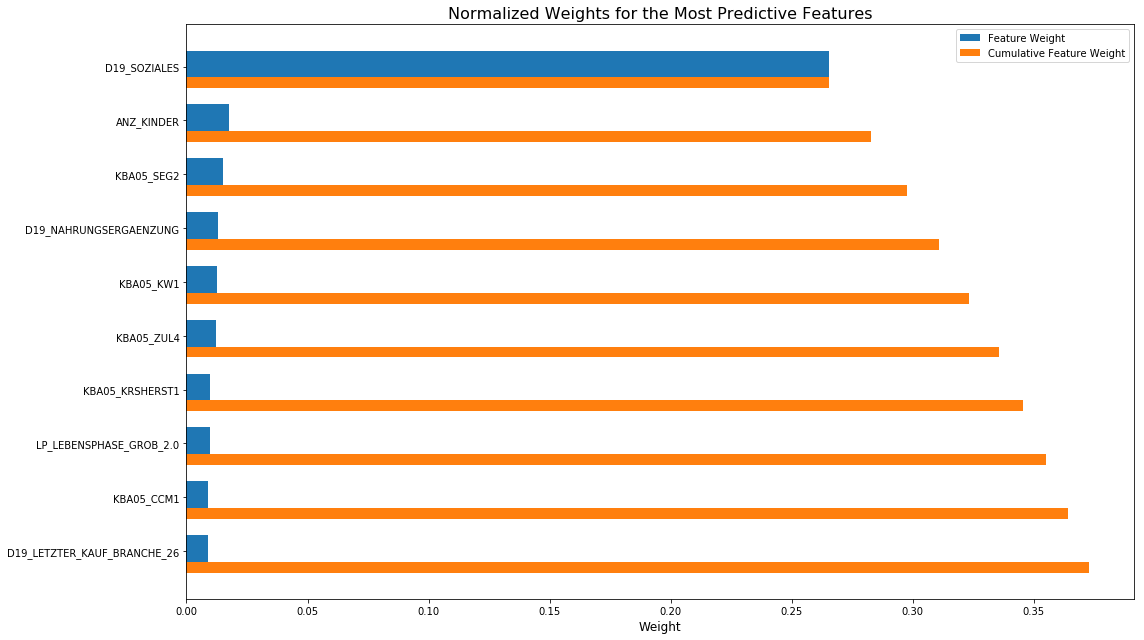

In [308]:
datefeature_plot(importance_features, features_raw, response_raw, 10)

In [287]:
over_cluster['D19_SOZIALES'].describe(), under_cluster['D19_SOZIALES'].describe()

(count    32530.000000
 mean         1.280653
 std          1.010180
 min         -0.871525
 25%          0.817327
 50%          1.032814
 75%          1.277330
 max          5.696715
 Name: D19_SOZIALES, dtype: float64, count    1046.000000
 mean        1.311707
 std         0.991089
 min        -0.378818
 25%         0.892150
 50%         1.083066
 75%         1.280316
 max         5.258129
 Name: D19_SOZIALES, dtype: float64)

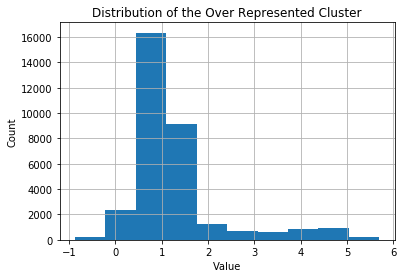

In [309]:
over_cluster['D19_SOZIALES'].hist()
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Distribution of the Over Represented Cluster');

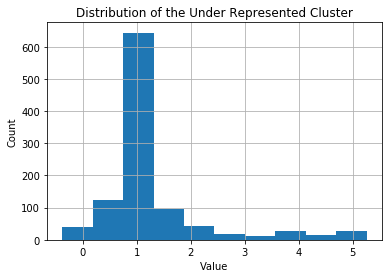

In [310]:
under_cluster['D19_SOZIALES'].hist()
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Distribution of the Under Represented Cluster');

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [291]:
print(mailout_test.shape)
mailout_test.head()

(42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [294]:
#clean up testing mailout dataset
mailout_test_clean = cleanup_dataset(mailout_test)

In [296]:
# Check for missing column in `clean_mailout_test`
missing_test_features = list(np.setdiff1d(customers_clean.columns, mailout_test_clean.columns))
missing_test_features

['ALTERSKATEGORIE_FEIN_1.0',
 'ALTER_HH_1.0',
 'D19_BANKEN_ONLINE_QUOTE_12_1.0',
 'EINGEZOGENAM_HH_JAHR_1900.0',
 'EINGEZOGENAM_HH_JAHR_1904.0',
 'EINGEZOGENAM_HH_JAHR_1971.0',
 'EINGEZOGENAM_HH_JAHR_1984.0',
 'EINGEZOGENAM_HH_JAHR_1986.0',
 'GEBAEUDETYP_5.0',
 'TITEL_KZ_2.0']

In [297]:
# Add the missing column with default value of 0
for m in missing_test_features:
    mailout_test_clean[m] = 0
    mailout_test_clean[m] = mailout_test_clean[m].astype('uint8')
mailout_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 974 entries, AKT_DAT_KL to TITEL_KZ_2.0
dtypes: float64(213), int64(69), uint8(692)
memory usage: 120.4 MB


In [300]:
pipeline = create_pipeline(clf_gbr_4)
pipeline.fit(features_raw, response_raw)

Pipeline(memory=None,
         steps=[('imp',
                 Imputer(axis=0, copy=True, missing_values='NaN',
                         strategy='mean', verbose=0)),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingRegressor(alpha=0.7, criterion='friedman_mse',
                                           init=None, learning_rate=0.01,
                                           loss='ls', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=13,
                                           min_samples_split=9,
                                           min_weight_fraction_leaf=0.0,
                     

In [301]:
#Predict on the test data
predictions = pipeline.predict(mailout_test_clean)

#### Create Submission file

In [303]:
competition_submission_df = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=predictions)
competition_submission_df.rename(columns={0: "RESPONSE"}, inplace=True)
competition_submission_df.head()

,RESPONSE
LNR,
1754,0.036626
1770,0.025032
1465,0.041333
1470,-0.000123
1478,0.013536


In [ ]:
#create a competition csv file which contains its prediction results
Competition_Submission.to_csv('competition_submission.csv')